In [ ]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Generator

In [ ]:
# Generator and Discriminator Definitions with Reduced Layers
class DownSample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(DownSample, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        down = self.model(x)
        return down

class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(Upsample, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(Output_Channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        self.up1 = Upsample(512, 256)
        self.up2 = Upsample(512, 128)
        self.up3 = Upsample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4, d3)
        u2 = self.up2(u1, d2)
        u3 = self.up3(u2, d1)
        u4 = self.final(u3)
        return u4

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## checking gen and disc models

In [ ]:
image = torch.rand((1,3,128,128))
out_channels = 3
generator = Generator()
k = generator(image)
print(k.shape)

torch.Size([1, 3, 128, 128])


In [ ]:
image1 = torch.rand((1,3,128,128))
image2 = torch.rand((1,3,128,128))

out_channels = 3
discriminator = Discriminator()
k = discriminator(image1,image2)
print(k.shape)

torch.Size([1, 1, 15, 15])


### loading data

In [ ]:
# Adjusted Image Dimensions and Paths
data_dir = '/content/drive/MyDrive/thermal visible scenery dataset'
train_subdir = "V2 Paired new"
val_subdir = "V1 Paired new"

In [ ]:
# Updated Transformations for 128x128 Images
data_transform = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.CenterCrop((128, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.bmp')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# Loading Training and Validation Data
dataset_train = CustomImageDataset(image_dir=os.path.join(data_dir, train_subdir), transform=data_transform)
dataset_val = CustomImageDataset(image_dir=os.path.join(data_dir, val_subdir), transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=24, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=False, num_workers=2)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

648
72


# Defining print finctions to show images


In [ ]:
def print_images(image_tensor, num_images):

    images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Checking loaded images

In [ ]:
#images,_ = next(iter(dataloader_train))
images = next(iter(dataloader_train))

images.shape

torch.Size([24, 3, 128, 256])

### Perceptual loss function

In [ ]:
# Training Functions
Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def DeNormalize(tensor_of_image):
    return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

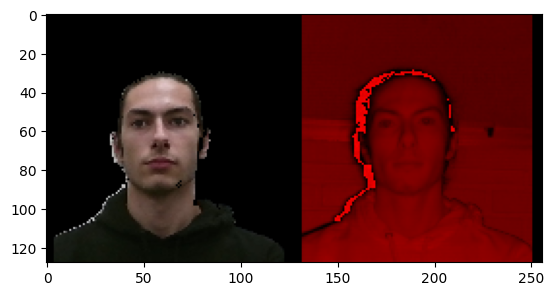

In [ ]:
images = next(iter(dataloader_train))

for image in images:
  plt.imshow(DeNormalize(image).permute(1,2,0))
  plt.show()
  break;

# Defining Loss Functions

In [ ]:
# Perceptual Loss Definition
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features.eval()
        self.features = nn.Sequential(*list(vgg.children())[:36])
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, generated, target):
        generated_features = self.features(generated)
        target_features = self.features(target)
        return nn.functional.mse_loss(generated_features, target_features)

In [ ]:
loss_comparison = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()

# Discriminator Training

In [ ]:
def discriminator_training(inputs,targets,discriminator_opt):

        discriminator_opt.zero_grad()


        # Passing real image and getting loss

        output = discriminator(inputs, targets)
        label = torch.ones(size = output.shape, dtype=torch.float, device=device)

        real_loss = loss_comparison(output, label)

        # Passing Generated image and getting loss

        gen_image = generator(inputs).detach()

        fake_output = discriminator(inputs, gen_image)
        fake_label = torch.zeros(size = fake_output.shape, dtype=torch.float, device=device)

        fake_loss = loss_comparison(fake_output, fake_label)

        Total_loss = (real_loss + fake_loss)/2

        Total_loss.backward()

        discriminator_opt.step()

        return Total_loss

# Generator Training

In [ ]:
def generator_training(inputs,targets, generator_opt, L1_lambda):
  generator_opt.zero_grad()

  generated_image = generator(inputs)

  disc_output = discriminator(inputs, generated_image)
  desired_output = torch.ones(size = disc_output.shape, dtype=torch.float, device=device)

  generator_loss = loss_comparison(disc_output, desired_output) + L1_lambda * torch.abs(generated_image-targets).sum()
  generator_loss.backward()
  generator_opt.step()

  return generator_loss, generated_image

# Start Training Process

In [ ]:
L1_lambda = 100
NUM_EPOCHS= 10
lr=0.0002
beta1=0.5
beta2=0.999
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.optim as optim

In [ ]:
discriminator_opt = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
generator_opt = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

discriminator = discriminator.to(device)
generator = generator.to(device)

In [ ]:
# Assuming you have a class definition for your models
new_discriminator = Discriminator()  # Replace with your model class
new_generator = Generator()           # Replace with your model class

# Move new models to the device (GPU or CPU)
new_discriminator = new_discriminator.to(device)
new_generator = new_generator.to(device)

# Create new optimizers for the new models
discriminator_opt = optim.Adam(new_discriminator.parameters(), lr=lr, betas=(beta1, beta2))
generator_opt = optim.Adam(new_generator.parameters(), lr=lr, betas=(beta1, beta2))


Training epoch 1


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 2


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 3


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 4


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 5


  0%|          | 0/27 [00:00<?, ?it/s]

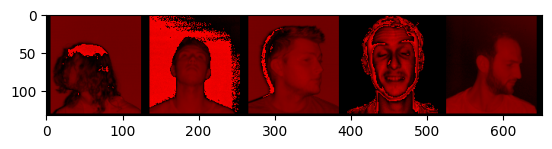

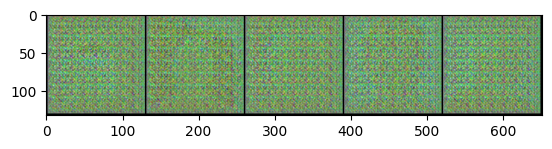

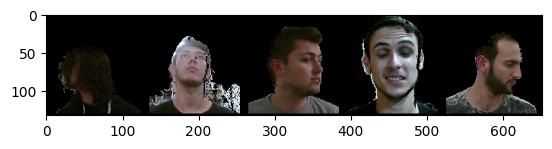

Model saved for epoch 5
Training epoch 6


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 7


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 8


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 9


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 10


  0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

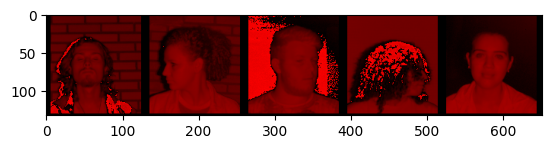

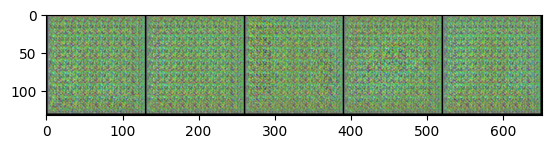

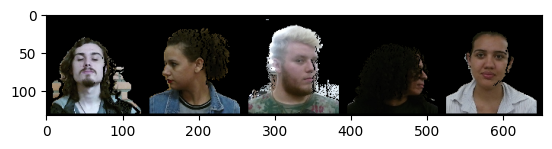

Model saved for epoch 10


In [ ]:
import torch

# Save model function
def save_model(epoch, new_generator, new_discriminator, generator_opt, discriminator_opt, path="model_checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': new_generator.state_dict(),
        'discriminator_state_dict': new_discriminator.state_dict(),
        'generator_opt_state_dict': generator_opt.state_dict(),
        'discriminator_opt_state_dict': discriminator_opt.state_dict()
    }, path)
    print(f"Model saved for epoch {epoch}")

for epoch in range(1, NUM_EPOCHS+1):
    print(f"Training epoch {epoch}")
    for images in tqdm(dataloader_train):

       inputs = images[:,:,:,128:].to(device) #visible on left
       targets = images[:,:,:,:128].to(device) #infrared on right

       # Train Discriminator
       Disc_Loss = discriminator_training(inputs,targets,discriminator_opt)

       # Train Generator
       for i in range(2):
            Gen_Loss, generator_image = generator_training(inputs,targets, generator_opt, L1_lambda)

    if (epoch % 5) == 0:
         print_images(inputs,5)
         print_images(generator_image,5)
         print_images(targets,5)
         # Save model after each epoch
         save_model(epoch, new_generator, new_discriminator, generator_opt, discriminator_opt, path=f"model_correct_epoch_{epoch}.pth")


In [ ]:
# Load model function
def load_model(path, new_generator, new_discriminator, generator_opt, discriminator_opt):
    checkpoint = torch.load(path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_opt.load_state_dict(checkpoint['generator_opt_state_dict'])
    discriminator_opt.load_state_dict(checkpoint['discriminator_opt_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Model loaded from epoch {epoch}")
    return epoch

# Example of loading a saved model
start_epoch = load_model("model_correct_epoch_10.pth", generator, discriminator, generator_opt, discriminator_opt)

Model loaded from epoch 10


<ipython-input-48-e88dc6982848>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Training epoch 11


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 12


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 13


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 14


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 15


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 16


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 17


  0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
Exception ignored

Training epoch 18


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 19


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 20


  0%|          | 0/27 [00:00<?, ?it/s]

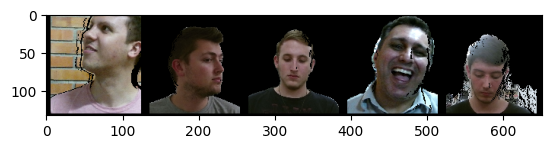

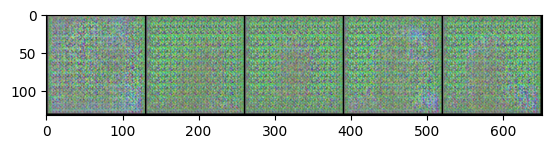

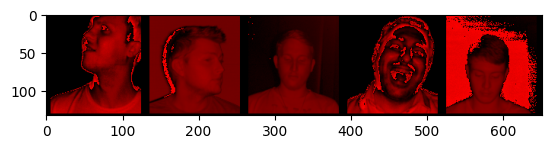

Model saved for epoch 20
Training epoch 21


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 22


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 23


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 24


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 25


  0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Training epoch 26


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 27


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 28


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 29


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 30


  0%|          | 0/27 [00:00<?, ?it/s]

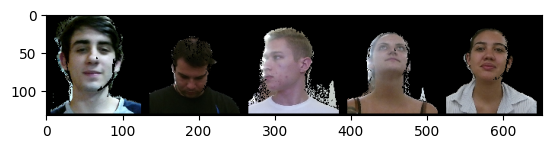

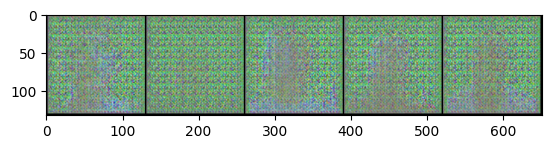

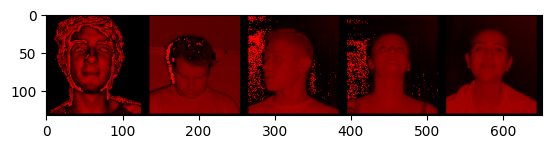

Model saved for epoch 30
Training epoch 31


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 32


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 33


  0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Training epoch 34


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 35


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 36


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 37


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 38


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 39


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 40


  0%|          | 0/27 [00:00<?, ?it/s]

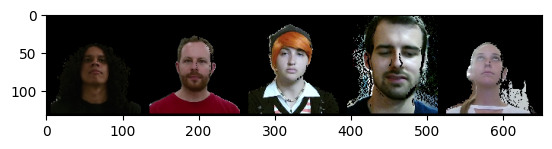

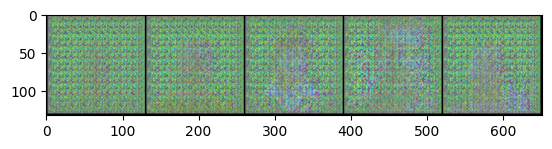

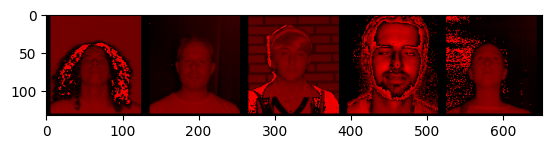

Model saved for epoch 40
Training epoch 41


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 42


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 43


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 44


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 45


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 46


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 47


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 48


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 49


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 50


  0%|          | 0/27 [00:00<?, ?it/s]

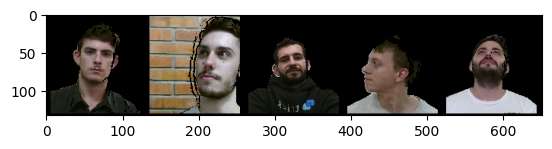

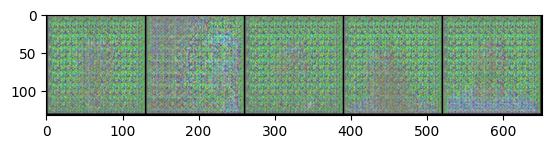

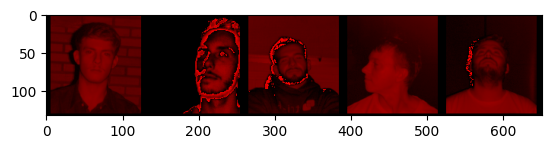

Model saved for epoch 50
Training epoch 51


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 52


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 53


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 54


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 55


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 56


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 57


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 58


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 59


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 60


  0%|          | 0/27 [00:00<?, ?it/s]

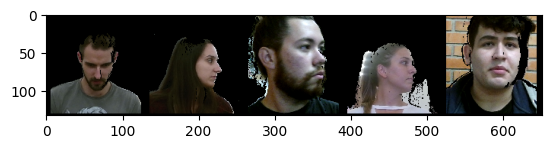

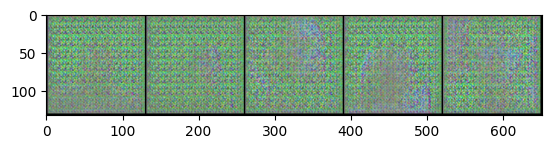

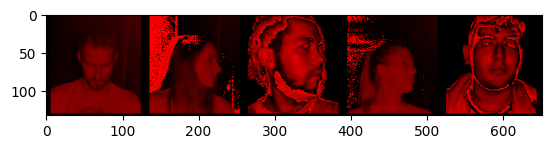

Model saved for epoch 60
Training epoch 61


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 62


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 63


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 64


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 65


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 66


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 67


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 68


  0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Training epoch 69


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 70


  0%|          | 0/27 [00:00<?, ?it/s]

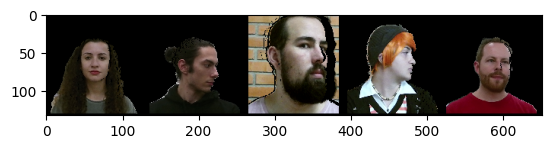

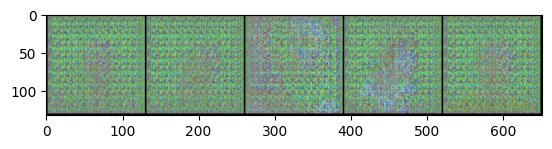

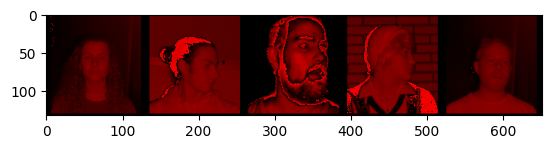

Model saved for epoch 70
Training epoch 71


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 72


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 73


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 74


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 75


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 76


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 77


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 78


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 79


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 80


  0%|          | 0/27 [00:00<?, ?it/s]

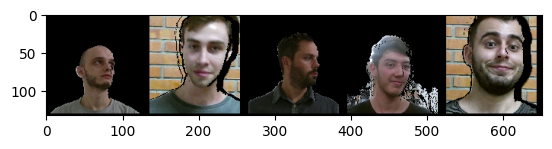

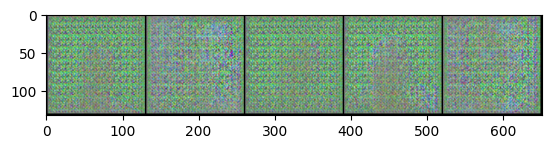

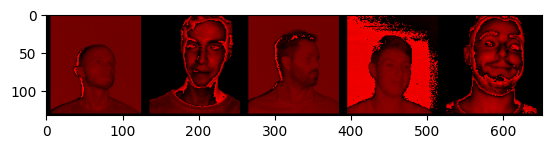

Model saved for epoch 80
Training epoch 81


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 82


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 83


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 84


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 85


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 86


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 87


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 88


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 89


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 90


  0%|          | 0/27 [00:00<?, ?it/s]

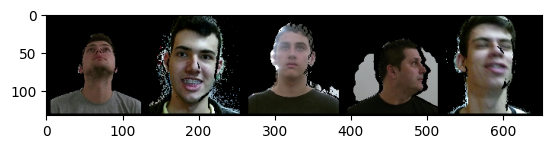

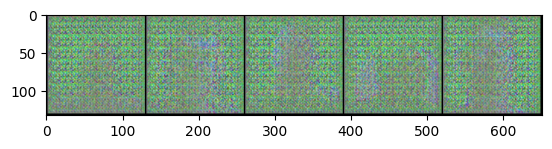

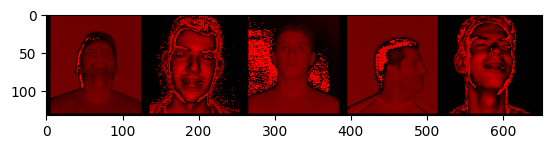

Model saved for epoch 90
Training epoch 91


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 92


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 93


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 94


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 95


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 96


  0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba6bccda8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Training epoch 97


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 98


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 99


  0%|          | 0/27 [00:00<?, ?it/s]

Training epoch 100


  0%|          | 0/27 [00:00<?, ?it/s]

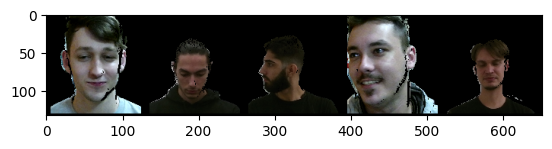

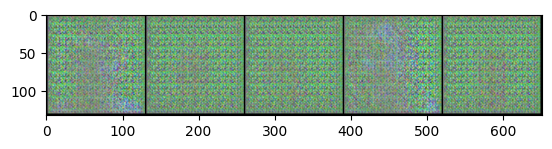

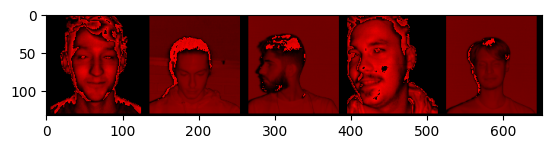

Model saved for epoch 100


In [ ]:
num_of_epochs_new = 100


# Now continue training from where you left off
for epoch in range(start_epoch+1, num_of_epochs_new+1):
    print(f"Training epoch {epoch}")
    for images in tqdm(dataloader_train):
       # Splitting the image
       inputs = images[:,:,:,:128].to(device)
       targets = images[:,:,:,128:].to(device)

       # Train Discriminator
       Disc_Loss = discriminator_training(inputs, targets, discriminator_opt)


       # Train Generator
       for i in range(2):
            Gen_Loss, generator_image = generator_training(inputs, targets, generator_opt, L1_lambda)

    if (epoch % 10) == 0:
         print_images(inputs, 5)
         print_images(generator_image, 5)
         print_images(targets, 5)

         # Save the model again after every epoch
         save_model(epoch, new_generator, new_discriminator, generator_opt, discriminator_opt, path=f"model_correct_epoch_{epoch}.pth")
         # save_model(epoch, new_generator, new_discriminator, generator_opt, discriminator_opt, path=f"model_epoch_{epoch}.pth")


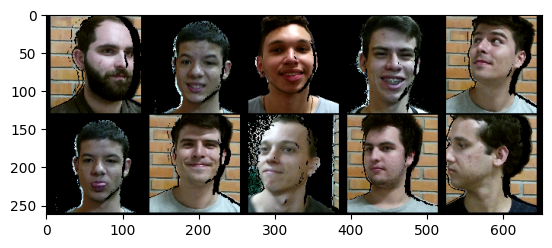

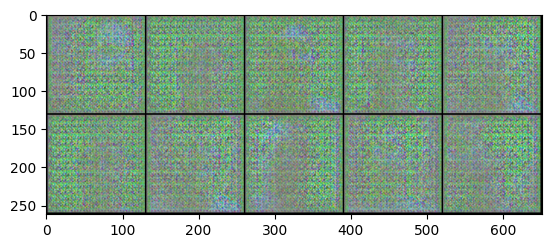

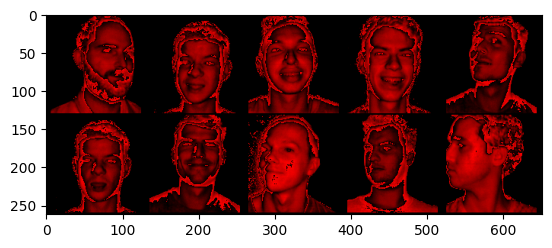

In [ ]:
test_imgs = next(iter(dataloader_val))


visible = test_imgs[:,:,:,128:].to(device)
infrared = test_imgs[:,:,:,:128].to(device)

gen = generator(infrared)
#gen = gen[0]

ther = infrared.detach().cpu()
gen = gen.detach().cpu()
visi = visible.detach().cpu()

print_images(ther,10)
print_images(gen,10)
print_images(visi,10)
